# Multi-Class Image Classification Deep Learning Model for ASL Alphabet Images Using TensorFlow Take 2
### David Lowe
### August 17, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using a TensorFlow convolutional neural network (CNN) and document the end-to-end steps using a template. The Kaggle ASL Alphabet Images dataset is a multi-class classification situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: The data set is a collection of alphabets from the American Sign Language, separated into 29 folders representing the various classes. The training data set contains 87,000 images which are 200x200 pixels. There are 29 classes, of which 26 are for the letters A-Z and three labels for SPACE, DELETE, and NOTHING. The test data set contains only 28 images to encourage the use of real-world test images.

In this Take2 iteration, we will construct a CNN model based on the VGG19 architecture to predict the ASL alphabet letters based on the available images.

ANALYSIS: In this Take2 iteration, the VGG19 model's performance achieved an accuracy score of 100% after ten epochs using the training dataset. The same model processed the validation dataset with an accuracy measurement of 95.33%. Finally, the final model processed the test dataset with an accuracy score of 100%.

CONCLUSION: In this iteration, the VGG19-based CNN model appeared to be suitable for modeling this dataset. We should consider experimenting with TensorFlow for further modeling.

Dataset Used: Kaggle ASL Alphabet Images

Dataset ML Model: Multi-class image classification with numerical attributes

Dataset Reference: https://www.kaggle.com/grassknoted/asl-alphabet

One potential source of performance benchmarks: https://www.kaggle.com/grassknoted/asl-alphabet/code

A deep-learning image classification project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Images
3. Define and Train Models
4. Evaluate and Optimize Models
5. Finalize Model and Make Predictions

# Task 1 - Prepare Environment

In [1]:
# Install the packages to support accessing environment variable and SQL databases
# !pip install python-dotenv PyMySQL boto3

In [2]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Fri Aug 13 17:54:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    48W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [4]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


## 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [6]:
# Load libraries and packages
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
from datetime import datetime
import zipfile
import h5py
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

## 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
VAL_SET_RATIO = 0.2
# TEST_SET_RATIO = 0.5

# Set various default modeling parameters
DEFAULT_LOSS = 'categorical_crossentropy'
DEFAULT_METRICS = ['accuracy']
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0001)
DEFAULT_INITIALIZER = tf.keras.initializers.RandomNormal(seed=RNG_SEED)
CLASSIFIER_ACTIVATION = 'softmax'
MAX_EPOCHS = 10
BATCH_SIZE = 32
# RAW_IMAGE_SIZE = (100, 100)
TARGET_IMAGE_SIZE = (224, 224)
INPUT_IMAGE_SHAPE = (TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1], 3)

NUM_CLASSES = 29
CLASS_LABELS = ['A','B','C','D','E',
                'F','G','H','I','J',
                'K','L','M','N','O',
                'P','Q','R','S','T',
                'U','V','W','X','Y',
                'Z','del','nothing','space']
# CLASS_NAMES = []

# Define the labels to use for graphing the data
train_metric = "accuracy"
validation_metric = "val_accuracy"
train_loss = "loss"
validation_loss = "val_loss"

# Define the directory locations and file names
STAGING_DIR = 'staging/'
TRAIN_DIR = 'staging/asl_alphabet_train/asl_alphabet_train/'
# VALID_DIR = ''
TEST_DIR = 'staging/asl_alphabet_test/asl_alphabet_test/'
# TRAIN_DATASET = ''
# VALID_DATASET = ''
# TEST_DATASET = ''
# TRAIN_LABELS = ''
# VALID_LABELS = ''
# TEST_LABELS = ''
# OUTPUT_DIR = 'staging/'
# SAMPLE_SUBMISSION_CSV = 'sample_submission.csv'
# FINAL_SUBMISSION_CSV = 'submission.csv'

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.5.0


In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [10]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [11]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Load and Prepare Images

In [12]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [13]:
!rm -rf staging/
!mkdir staging/
# !rm archive_asl_alphabet.zip
if not os.path.exists('archive_asl_alphabet.zip'):
    !wget https://dainesanalytics.com/datasets/kaggle-asl-alphabet-images/archive_asl_alphabet.zip

In [14]:
dataset_zip = 'archive_asl_alphabet.zip'
zip_ref = zipfile.ZipFile(dataset_zip, 'r')
zip_ref.extractall(STAGING_DIR)
zip_ref.close()

In [15]:
# Brief listing of training image files for each class
for c_label in CLASS_LABELS:
    training_class_dir = os.path.join(TRAIN_DIR, c_label)
    training_class_files = os.listdir(training_class_dir)
    print('Number of training images for', c_label, ':', len(os.listdir(training_class_dir)))
    print('Training samples for', c_label, ':', training_class_files[:5])

Number of training images for A : 3000
Training samples for A : ['A1426.jpg', 'A1503.jpg', 'A2206.jpg', 'A2821.jpg', 'A2014.jpg']
Number of training images for B : 3000
Training samples for B : ['B2465.jpg', 'B2625.jpg', 'B2908.jpg', 'B1429.jpg', 'B2703.jpg']
Number of training images for C : 3000
Training samples for C : ['C1537.jpg', 'C2901.jpg', 'C2712.jpg', 'C904.jpg', 'C1230.jpg']
Number of training images for D : 3000
Training samples for D : ['D429.jpg', 'D144.jpg', 'D333.jpg', 'D2979.jpg', 'D2265.jpg']
Number of training images for E : 3000
Training samples for E : ['E252.jpg', 'E1976.jpg', 'E1215.jpg', 'E2658.jpg', 'E2974.jpg']
Number of training images for F : 3000
Training samples for F : ['F497.jpg', 'F2602.jpg', 'F1384.jpg', 'F2945.jpg', 'F316.jpg']
Number of training images for G : 3000
Training samples for G : ['G2224.jpg', 'G916.jpg', 'G2526.jpg', 'G854.jpg', 'G705.jpg']
Number of training images for H : 3000
Training samples for H : ['H865.jpg', 'H881.jpg', 'H835.jpg',

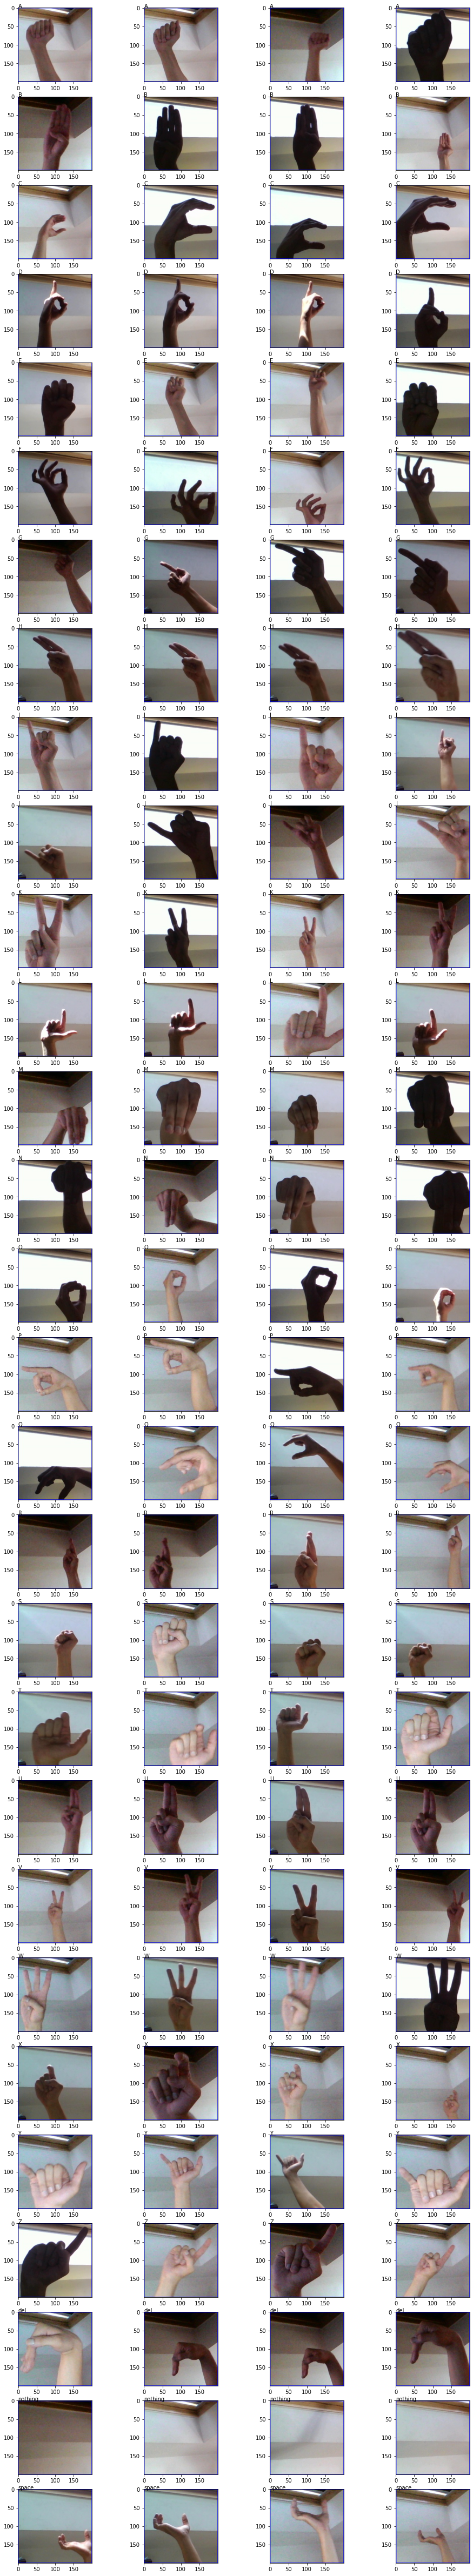

In [16]:
# Plot some training images from the dataset
nrows = NUM_CLASSES
ncols = 4
training_examples = []
example_labels = []

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 3)

for c_label in CLASS_LABELS:
    training_class_dir = os.path.join(TRAIN_DIR, c_label)
    training_class_files = os.listdir(training_class_dir)
    for j in range(ncols):
        training_examples.append(c_label+'/'+training_class_files[j])
        example_labels.append(c_label)
    # print(training_examples)
    # print(example_labels)

for i, img_path in enumerate(training_examples):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i+1)
    sp.text(0, 0, example_labels[i])
    # sp.axis('Off')
    img = mpimg.imread(TRAIN_DIR + img_path)
    plt.imshow(img)
plt.show()

In [17]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Define and Train Models

In [18]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [19]:
datagen_kwargs = dict(rescale=1./255, validation_split=VAL_SET_RATIO)
training_datagen = ImageDataGenerator(**datagen_kwargs)
validation_datagen = ImageDataGenerator(**datagen_kwargs)
dataflow_kwargs = dict(class_mode="categorical")

do_data_augmentation = False
if do_data_augmentation:
    training_datagen = ImageDataGenerator(rotation_range=90,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          **datagen_kwargs)

print('Loading and pre-processing the training images...')
training_generator = training_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                          target_size=TARGET_IMAGE_SIZE,
                                                          batch_size=BATCH_SIZE,
                                                          shuffle=True,
                                                          seed=RNG_SEED,
                                                          subset="training",
                                                          **dataflow_kwargs)
print('Number of training image batches per epoch of modeling:', len(training_generator))

print('Loading and pre-processing the validation images...')
validation_generator = validation_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                              target_size=TARGET_IMAGE_SIZE,
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=False,
                                                              subset="validation",
                                                              **dataflow_kwargs)
print('Number of validation image batches per epoch of modeling:', len(validation_generator))

Loading and pre-processing the training images...
Found 69600 images belonging to 29 classes.
Number of training image batches per epoch of modeling: 2175
Loading and pre-processing the validation images...
Found 17400 images belonging to 29 classes.
Number of validation image batches per epoch of modeling: 544


In [20]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [train_loss, train_metric]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == train_loss:
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0.5, 1.1])
        plt.legend()

In [21]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=INPUT_IMAGE_SHAPE, output_param=NUM_CLASSES, dense_nodes=2048,
                    init_param=DEFAULT_INITIALIZER, classifier_activation=CLASSIFIER_ACTIVATION,
                    loss_param=DEFAULT_LOSS, opt_param=DEFAULT_OPTIMIZER, metrics_param=DEFAULT_METRICS):
    base_model = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=input_param)
    nn_model = keras.models.Sequential()
    nn_model.add(base_model)
    nn_model.add(keras.layers.Flatten())
    nn_model.add(keras.layers.Dense(dense_nodes, activation='relu', kernel_initializer=init_param)),
    nn_model.add(keras.layers.Dense(output_param, activation=classifier_activation))
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [22]:
# Initialize the neural network model and get the training results for plotting graph
start_time_module = datetime.now()
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
reset_random()
nn_model_0 = create_nn_model()
nn_model_history = nn_model_0.fit(training_generator,
                                  epochs=MAX_EPOCHS,
                                  validation_data=validation_generator,
                                #   callbacks=[learning_rate_reduction],
                                  verbose=1)
print('Total time for model fitting:', (datetime.now() - start_time_module))

Epoch 1/10
2175/2175 [==============================] - 594s 270ms/step - loss: 0.3740 - accuracy: 0.8910 - val_loss: 0.2857 - val_accuracy: 0.9330
Epoch 2/10
2175/2175 [==============================] - 584s 268ms/step - loss: 0.0262 - accuracy: 0.9925 - val_loss: 0.3934 - val_accuracy: 0.9160
Epoch 3/10
2175/2175 [==============================] - 583s 268ms/step - loss: 0.0305 - accuracy: 0.9918 - val_loss: 0.2754 - val_accuracy: 0.9391
Epoch 4/10
2175/2175 [==============================] - 583s 268ms/step - loss: 0.0107 - accuracy: 0.9973 - val_loss: 0.4185 - val_accuracy: 0.9565
Epoch 5/10
2175/2175 [==============================] - 582s 267ms/step - loss: 0.0164 - accuracy: 0.9960 - val_loss: 0.2716 - val_accuracy: 0.9193
Epoch 6/10
2175/2175 [==============================] - 583s 268ms/step - loss: 0.0134 - accuracy: 0.9965 - val_loss: 0.2663 - val_accuracy: 0.9379
Epoch 7/10
2175/2175 [==============================] - 583s 268ms/step - loss: 1.5248e-04 - accuracy: 1.0000 - 

In [23]:
nn_model_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 2048)              51382272  
_________________________________________________________________
dense_1 (Dense)              (None, 29)                59421     
Total params: 71,466,077
Trainable params: 71,466,077
Non-trainable params: 0
_________________________________________________________________


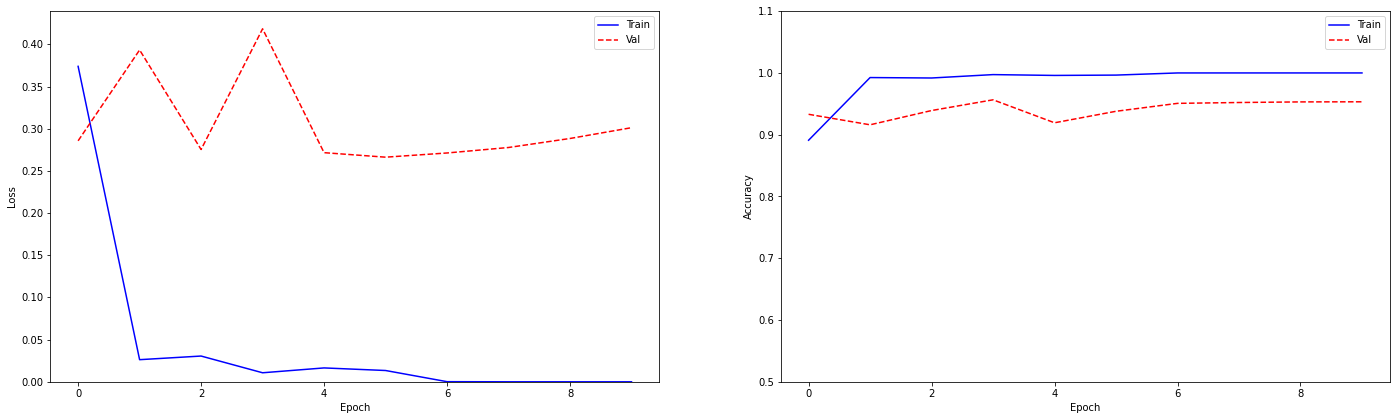

In [24]:
plot_metrics(nn_model_history)

In [25]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Evaluate and Optimize Models

In [26]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [27]:
# Not applicable for this iteration of modeling

In [28]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Make Predictions

In [29]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [30]:
final_model = nn_model_0
final_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 2048)              51382272  
_________________________________________________________________
dense_1 (Dense)              (None, 29)                59421     
Total params: 71,466,077
Trainable params: 71,466,077
Non-trainable params: 0
_________________________________________________________________


In [31]:
testing_class_files = os.listdir(TEST_DIR)
print('Number of test images found:', len(testing_class_files))

Number of test images found: 28


In [32]:
test_images_df = pd.DataFrame(columns=['image_name','class_label'])
for image_file in testing_class_files:
    image_name = image_file
    class_label = image_name[0:image_file.find('_test')]
    # print('Found image:', image_name, 'with the class:', class_label)
    df_record = {'image_name': image_name,
                 'class_label': class_label}
    test_images_df = test_images_df.append(df_record, ignore_index=True)
print(test_images_df.head())

   image_name class_label
0  X_test.jpg           X
1  U_test.jpg           U
2  N_test.jpg           N
3  L_test.jpg           L
4  W_test.jpg           W


In [33]:
print('Loading and pre-processing the testing images...')
testing_datagen = ImageDataGenerator(**datagen_kwargs)
testing_generator = testing_datagen.flow_from_dataframe(dataframe=test_images_df,
                                                        directory=TEST_DIR,
                                                        x_col='image_name',
                                                        y_col='class_label',
                                                        classes=CLASS_LABELS,
                                                        target_size=TARGET_IMAGE_SIZE,
                                                        shuffle=False,
                                                        **dataflow_kwargs)
print('Number of image batches per epoch of modeling:', len(testing_generator))

Loading and pre-processing the testing images...
Found 28 validated image filenames belonging to 29 classes.
Number of image batches per epoch of modeling: 1


In [34]:
final_model.evaluate(testing_generator, verbose=1)

1/1 [==============================] - 3s 3s/step - loss: 3.7294e-06 - accuracy: 1.0000


[3.729353238668409e-06, 1.0]

In [35]:
test_predictions = np.argmax(final_model.predict(testing_generator), axis=-1)
test_originals = testing_generator.labels
print('Accuracy Score:', accuracy_score(test_originals, test_predictions))
print(confusion_matrix(test_originals, test_predictions))
print(classification_report(test_originals, test_predictions))

Accuracy Score: 1.0
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 

In [36]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [37]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 1:38:19.462404
